In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt    # for plotting the images
import os
import numpy as np

In [2]:
import import_ipynb
from utils import intersection_over_union, mean_average_precision

importing Jupyter notebook from utils.ipynb


<img src = "images/box.png" width = "200px"/>

In [3]:
classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}

In [18]:
GRIDS = 3

In [8]:
import cv2 as cv
import numpy as np

def read(image_path : str, label : list):
    '''
    Returns RGB image and label matrix from local path : 
    
    Parameter
    ---------
    image_path : str
    	Local path in string 
        
    label : list
    	list of string of labels in the format : [xmin, ymin, xmax, ymax, class_idx]
    
    Returns
    -------
    	RGB 448 x 448 image,[GRIDS x GRIDS x 30] label_matrix
    '''
    
    image_path = image_path.numpy()
    label = label.numpy()
    image = load_image_tf(image_path)
    #image = cv.imread(image_path)
    #image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_h, image_w = image.shape[0:2]
    #image = cv.resize(image, (448, 448))
    image = tf.image.resize(image, (448, 448))
    image = image / 255.
    label_matrix = np.zeros([GRIDS, GRIDS, 30]).astype(np.float64)
    for l in label:
        l = bytes.decode(l)
        l = l.split(',')
        l = np.array(l, dtype=np.int32)
        
        xmin = l[0]
        ymin = l[1]
        xmax = l[2]
        ymax = l[3]
        cls = l[4]
        cls = (1 if cls == 14 else 0)
        x = (xmin + xmax) / 2 / image_w 
        y = (ymin + ymax) / 2 / image_h
        w = (xmax - xmin) / image_w
        h = (ymax - ymin) / image_h
        loc = [GRIDS * x, GRIDS * y]
        loc_i = int(loc[1])
        loc_j = int(loc[0])
        y = loc[1] - loc_i
        x = loc[0] - loc_j
        w_cell = w * GRIDS
        h_cell = h * GRIDS  

        if label_matrix[loc_i, loc_j, 24] == 0:
            label_matrix[loc_i, loc_j, cls] = 1
            label_matrix[loc_i, loc_j, 20:24] = [x, y, w_cell, h_cell]
            label_matrix[loc_i, loc_j, 24] = 1  # response
 
    return [tf.cast(image, tf.float64), label_matrix.astype(np.float64)]

def load_image_tf(x) :
    #x = Full file path
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_image_cv(x) :
    #x = Full file path
    image = cv.imread(x)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

def load_file(x) :
    with open(x, 'r') as f :
        res = f.read().split(' ')
        return res[1:] #since the beginning of label file starts with space
    
def load_file_tf(x) :
    content = tf.io.read_file(x)
    content = tf.strings.split(content)
    return content

## Pre-processing
### Limit GPU memory growth
To ensure we dont have too many out of memory errors.

In [9]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load data into TensorFlow Dataset

In [5]:
image_files = tf.data.Dataset.list_files(os.path.join('train', 'aug_images', '*.jpg'), shuffle=False)

In [6]:
image_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [7]:
image_files.as_numpy_iterator().next()

b'train\\aug_images\\000012.0.jpg'

In [8]:
%%time 
load_image_tf(r'train\\aug_images\\000012.0.jpg').shape

CPU times: total: 15.6 ms
Wall time: 17 ms


TensorShape([448, 448, 3])

In [9]:
%%time 
load_image_cv(r'train\\aug_images\\000012.0.jpg').shape

CPU times: total: 15.6 ms
Wall time: 100 ms


(448, 448, 3)

In [10]:
image_files.map(load_image_tf).as_numpy_iterator().next().shape

(448, 448, 3)

In [11]:
label_files =  tf.data.Dataset.list_files(os.path.join('train', 'aug_labels', '*.txt'), shuffle=False)

In [12]:
label_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [13]:
label_files.as_numpy_iterator().next()

b'train\\aug_labels\\000012.0.txt'

In [14]:
%%time
load_file('train\\aug_labels\\000012.0.txt')

CPU times: total: 0 ns
Wall time: 6 ms


['55,197,262,343,6']

In [16]:
%%time
load_file_tf('train\\aug_labels\\000012.0.txt')

CPU times: total: 0 ns
Wall time: 15 ms


<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'55,197,262,343,6'], dtype=object)>

In [24]:
label_files

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [17]:
label_files_mapped = label_files.map(load_file_tf)

In [18]:
label_files_generator = label_files_mapped.as_numpy_iterator()

In [19]:
print(label_files_generator.next())
print(label_files_generator.next())

[b'55,197,262,343,6']
[b'92,215,209,317,6']


In [20]:
zipped = tf.data.Dataset.zip((image_files, label_files_mapped))
zipped_generator = zipped.as_numpy_iterator()

In [21]:
print(zipped_generator.next())
print(zipped_generator.next())

(b'train\\aug_images\\000012.0.jpg', array([b'55,197,262,343,6'], dtype=object))
(b'train\\aug_images\\000012.1.jpg', array([b'92,215,209,317,6'], dtype=object))


In [22]:
len(list(zipped))

232799

In [23]:
org_data = zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float64, tf.uint8]))
org_data_generator = org_data.as_numpy_iterator()

In [25]:
print(org_data_generator.next()[0].shape , org_data_generator.next()[1].shape, sep = '\n')

(448, 448, 3)
(7, 7, 30)


### Load data as partitioned dataset in correct format

In [10]:
batch_size = 4

In [11]:
images = tf.data.Dataset.list_files(os.path.join('train', 'images2', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('train', 'labels2', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
train = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float64, tf.float64]))
train = train.shuffle(10000)
train = train.batch(batch_size)
#train = train.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(train))

Lenth =  268


In [8]:
#!!!!!very expensive step (because of batch size with a prefetch)
#print(train.as_numpy_iterator().next()[0].shape , train.as_numpy_iterator().next()[1].shape, sep = '\n')

In [17]:
batch_size2 = 4

In [18]:
images = tf.data.Dataset.list_files(os.path.join('test', 'images', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('test', 'labels', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
test = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float64, tf.float64]))
test = test.shuffle(5000)
test = test.batch(batch_size2)
test = test.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(test))

Lenth =  1238


In [10]:
images = tf.data.Dataset.list_files(os.path.join('val', 'images', '*.jpg'), shuffle=False)
labels =  tf.data.Dataset.list_files(os.path.join('val', 'labels', '*.txt'), shuffle=False)
labels_mapped = labels.map(load_file_tf)
_zipped = tf.data.Dataset.zip((images, labels_mapped))
val = _zipped.map(lambda x1, x2 : tf.py_function(read, [x1, x2], [tf.float64, tf.float64]))
val = val.shuffle(5000)
val = val.batch(batch_size2)
val = val.prefetch(2)  #this avoids bottlenecks
print('Lenth = ', len(val))

Lenth =  10


## View Images and Annotations

In [10]:
data_samples_gen = train.as_numpy_iterator()

In [11]:
res = data_samples_gen.next()
start = 0

In [66]:
res[1].dtype

dtype('float64')

In [12]:
res[0].shape

(4, 448, 448, 3)

In [13]:
res[1].shape

(4, 3, 3, 30)

In [14]:
res[1][0, ..., 15]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

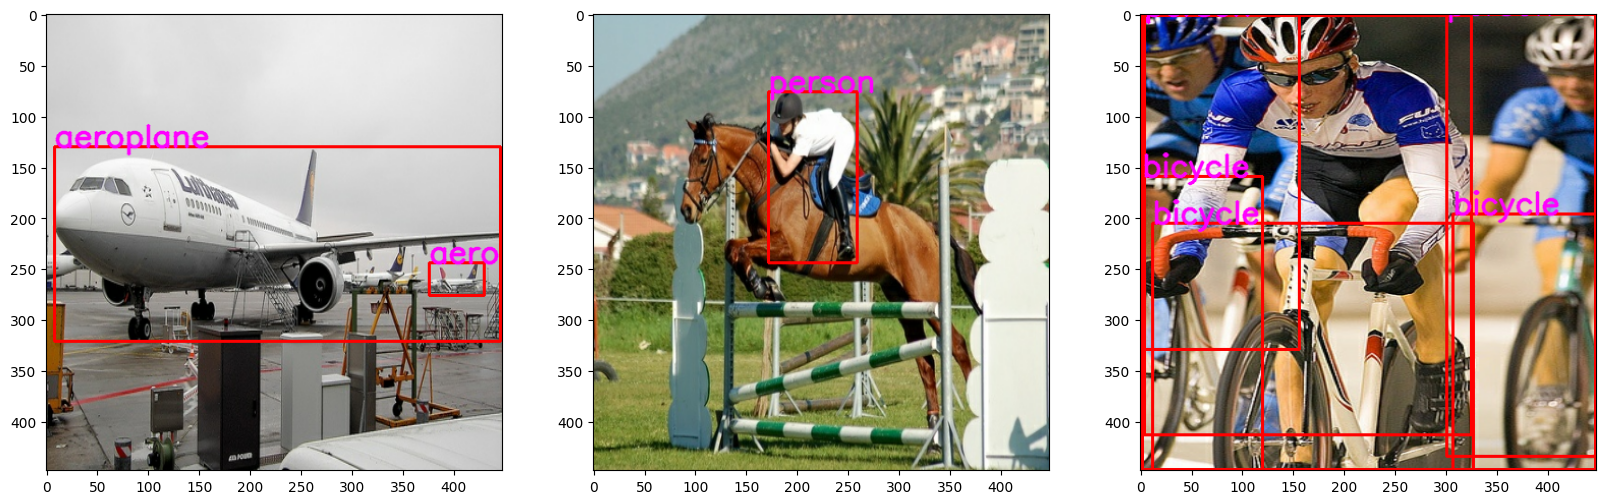

In [15]:
confidence_thresh = 0.1
grid_width = 1 / GRIDS
grid_dimen = np.array([448 * grid_width, 448 * grid_width]).astype(np.int32)
list_classes = list(classes_num)
plots = 3
fig, ax = plt.subplots(ncols=plots, figsize = (20, 20))
for idx in range(plots) :
    sample_image = (res[0][idx] * 255).astype(np.uint8)
    for i in range(GRIDS) :
        for j in range(GRIDS) :
            if res[1][idx, i, j, 24] < confidence_thresh: continue 
            sample_coords = res[1][idx,i, j, 20:24] #[x, y, w, h]
            
            width = sample_coords[2] * grid_dimen[0] 
            height = sample_coords[3] * grid_dimen[1]
            #width = sample_coords[2] * 448
            #height = sample_coords[3] * 448
            x1 = (j * grid_dimen[0]) + (sample_coords[0] * grid_dimen[0]) - (width / 2)
            y1 = (i * grid_dimen[1]) + (sample_coords[1] * grid_dimen[1]) - (height / 2)
            x2 = x1 + width
            y2 = y1 + height
            
            cv.rectangle(sample_image, 
                         tuple(np.array([x1, y1]).astype(np.int32)),
                         tuple(np.array([x2, y2]).astype(np.int32)),
                         (255, 0, 0),
                         2)
            
            cv.putText(img=sample_image,
                   text = list_classes[int(res[1][idx, i, j, :20].argmax())],
                   org = tuple(np.array([x1, y1]).astype(np.int32)),
                   fontFace = cv.FONT_HERSHEY_SIMPLEX,
                   fontScale = 1,
                   color = (255, 0, 255),
                   thickness =2,
                    lineType = cv.LINE_AA
                   )
    ax[idx].imshow(sample_image)
plt.show()

## YOLO model - Architecture
<img src = "images/yolo_v1_architecture.png"/>

### Defining a custom output layer
We need to reshape the output from the model so we define a custom Keras layer for it.

In [12]:
from tensorflow import keras
import keras.backend as K

class YoloActivation(tf.keras.layers.Layer) :
    
    def call(self, inputs) :
        classes = tf.nn.softmax(inputs[..., :20])
        coordinates = tf.sigmoid(inputs[..., 20:])
        return tf.concat([classes, coordinates], axis = -1)
        

### Building model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.2)

img_h=img_w=448

featureExtractor = Sequential()
featureExtractor.add(
    tf.keras.applications.VGG16(
        include_top=False, 
        weights = 'imagenet',
        input_shape =(img_h, img_w, 3)
    )
)

featureExtractor.trainable = False

model = Sequential()
model.add(featureExtractor)
model.add(GlobalMaxPooling2D())
#model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

#model.add(Flatten())
model.add(Dense(486, activation = lrelu))
model.add(Dropout(0.5))
#model.add(Dense(512, activation = lrelu))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(GRIDS * GRIDS * (20 + 5 * 2)))
model.add(Reshape((GRIDS , GRIDS , (20 + 5 * 2))))
model.add(YoloActivation())
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 14, 14, 512)       14714688  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 486)               249318    
                                                                 
 dropout_1 (Dropout)         (None, 486)               0         
                                                                 
 dense_2 (Dense)             (None, 270)              

### Define a custom learning rate scheduler
The paper uses different learning rates for different epochs. So we define a custom Callback function for the learning rate.

In [20]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"\nEpoch {epoch}: Learning rate is {scheduled_lr:.7f}")


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1e-3),
    (10, 1e-4),
    (25, 1e-5),
    (40, 1e-6),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

### Define the loss function
<img src = "images/loss_fn.png"/>

In [21]:
lambda_coord = 5
lambda_noobj = 0.5

## YOLO LOSS
def yoloLoss(y_true, y_pred) :
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    iou_b1 = intersection_over_union(y_pred[..., 20:24], y_true[..., 20:24])
    iou_b2 = intersection_over_union(y_pred[..., 25:29], y_true[..., 25:29])
    ious = tf.concat([tf.expand_dims(iou_b1, axis=0), tf.expand_dims(iou_b2, axis = 0)], axis = 0)
    bestbox = tf.cast(tf.argmax(ious, axis = 0), tf.float64)
    exists_box = y_true[..., 24:25] #identify function - tells us if there is obj in cell i
    
    #===========================#
    #     FOR BOX COORDINATES   #
    #===========================#
    box_predictions = tf.cast(exists_box, tf.float64) * tf.cast(
        bestbox * y_pred[..., 25:29]
        + (1 - bestbox) * y_pred[..., 20:24]
    , tf.float64)
    
    box_targets = exists_box * y_true[..., 20:24]
    
    temp = box_predictions.numpy()
    temp[..., 2:4] = tf.cast(tf.sign(box_predictions[..., 2:4]), dtype=tf.float64) * tf.sqrt(
        tf.cast(tf.abs(box_predictions[..., 2:4]), dtype=tf.float64) + 1e-6
    ).numpy()
    box_predictions = tf.convert_to_tensor(temp)

    
    temp = box_targets.numpy()
    temp[..., 2:4] = tf.sqrt(box_targets[..., 2:4]).numpy()
    box_targets = tf.convert_to_tensor(temp)
    
    box_loss = tf.keras.losses.mean_squared_error(
        tf.reshape(box_targets, (-1,) + (box_targets.shape[-1],)), 
        tf.reshape(box_predictions, (-1,) + (box_predictions.shape[-1],)), 
    )
    
    #===========================#
    #    FOR OBJECT LOSS        #
    #===========================#
    pred_box  = (
        bestbox * y_pred[..., 29:30] + (1 - bestbox) * y_pred[..., 24:25]
    )
    
    object_loss = tf.keras.losses.mean_squared_error(
        tf.reshape(exists_box * pred_box, (-1, 1)), 
        tf.reshape(exists_box * y_true[..., 24:25], (-1, 1)), 
    )
    
    #===========================#
    #    FOR NO OBJECT LOSS     #
    #===========================#
    no_object_loss = tf.keras.losses.mean_squared_error(
        tf.reshape((1 - exists_box) * y_pred[..., 24:25], (-1, 1)), 
        tf.reshape((1 - exists_box) * y_true[..., 24:25], (-1, 1)), 
    )
    
    no_object_loss += tf.keras.losses.mean_squared_error(
        tf.reshape((1 - exists_box) * y_pred[..., 29:30], (-1, 1)), 
        tf.reshape((1 - exists_box) * y_true[..., 24:25], (-1, 1)), 
    )
    
    #===========================#
    #    CLASS LOSS             #
    #===========================#
    
    class_loss = tf.keras.losses.mean_squared_error(
        tf.reshape(exists_box * y_pred[..., :20], (-1, 20)), 
        tf.reshape(exists_box * y_true[..., :20], (-1, 20)), 
    )
    loss = (
        tf.cast(lambda_coord, tf.float64) * tf.cast(box_loss, tf.float64)
        + object_loss
        + tf.cast(lambda_noobj, tf.float64) * no_object_loss
        + class_loss
    )
    
    return tf.reduce_sum(loss)

In [95]:
yoloLoss(res[1], res[1])

<tf.Tensor: shape=(), dtype=float64, numpy=6.493941911687596e-12>

### Adding a callback for saving the weights

In [22]:
# defining a function to save the weights of best model
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

### Adding a callback for stopping early

In [18]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss',)

### Compile the model
Finally, compile the model using the custom loss function thatlearning_rate= defined above.

In [23]:
from keras.optimizers import SGD, Adam

model.compile(loss=yoloLoss ,optimizer=Adam(learning_rate=1e-5), run_eagerly=True)

In [24]:
hist = model.fit(x=train,
          epochs = 100,
          verbose = 1,
          workers= 8,
          #validation_data = val,
           callbacks=[
              CustomLearningRateScheduler(lr_schedule),
              mcp_save,
              #early_stopping_callback
          ])


Epoch 0: Learning rate is 0.0010000
Epoch 1/100


: 

: 

In [ ]:
# Define a function to compute the forward and backward passes
@tf.function
def train_step(x, y_true):
    with tf.GradientTape() as tape:
        # Compute the forward pass
        y_pred = model(x, training=True) #None, GRIDS, GRIDS, 30
        # Compute the loss
        loss_value = yoloLoss(y_true, y_pred)
    # Compute the gradients
    grads = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value

# Run the custom training loop
for epoch in range(10):
    # Train on batches of data
    for x_batch, y_batch in train_dataset:
        loss_value = train_step(x_batch, y_batch)
        y_pred = model(x_batch, training = True)
        mAP = mean_average_precision(y_pred[..., 20:24], y_batch[..., 20:24], box_format='midpoint')

    # Print the loss value for this epoch
    print(f'Epoch {epoch}: Loss : {loss_value}, mAP : ')

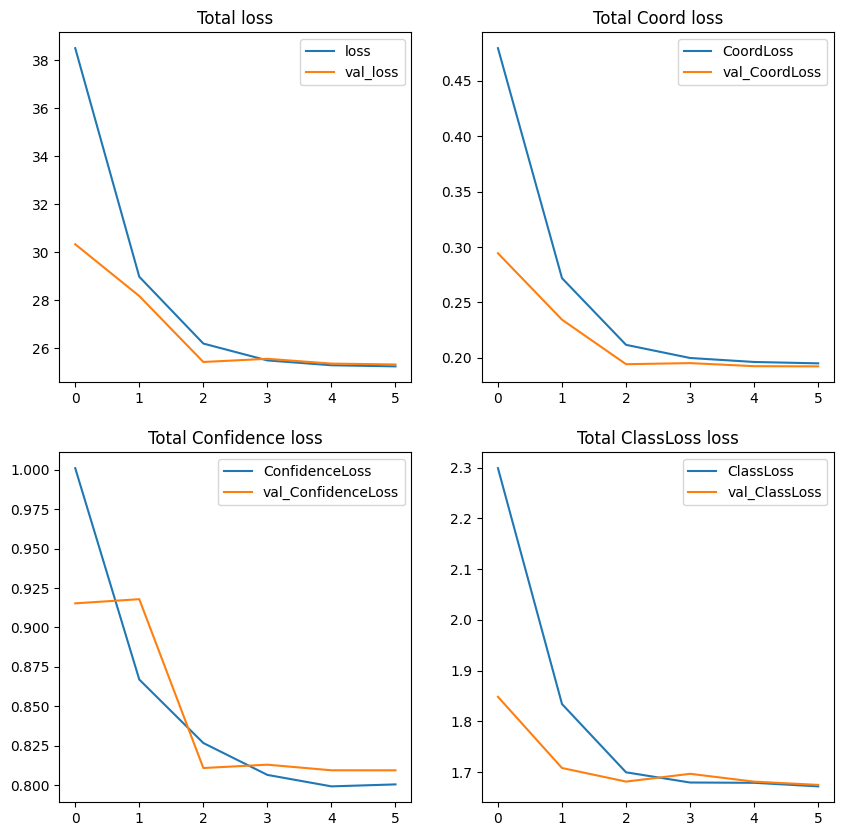

In [29]:
fig, ax = plt.subplots(ncols =2, nrows =2,  figsize= (10, 10))

ax[0][0].plot(hist.history['loss'], label = 'loss')
ax[0][0].plot(hist.history['val_loss'], label = 'val_loss')
ax[0][0].title.set_text('Total loss')
ax[0][0].legend()

ax[0][1].plot(hist.history['CoordLoss'], label = 'CoordLoss')
ax[0][1].plot(hist.history['val_CoordLoss'], label = 'val_CoordLoss')
ax[0][1].title.set_text('Total Coord loss')
ax[0][1].legend()

ax[1][0].plot(hist.history['ConfidenceLoss'], label = 'ConfidenceLoss')
ax[1][0].plot(hist.history['val_ConfidenceLoss'], label = 'val_ConfidenceLoss')
ax[1][0].title.set_text('Total Confidence loss')
ax[1][0].legend()

ax[1][1].plot(hist.history['ClassLoss'], label = 'ClassLoss')
ax[1][1].plot(hist.history['val_ClassLoss'], label = 'val_ClassLoss')
ax[1][1].title.set_text('Total ClassLoss loss')
ax[1][1].legend()


In [18]:
model.load_weights('weight_6.hdf5')

In [16]:
gen = train.as_numpy_iterator()

In [22]:
a = gen.next()

In [23]:
a[0].shape

(4, 448, 448, 3)

In [24]:
#model.compile(loss=yolo_loss ,optimizer='adam')
eval_ = model.predict(a[0])

1/1 [==============================] - 0s 47ms/step


In [25]:
res = (a[0], eval_)

In [ ]:
np.min(res[1])

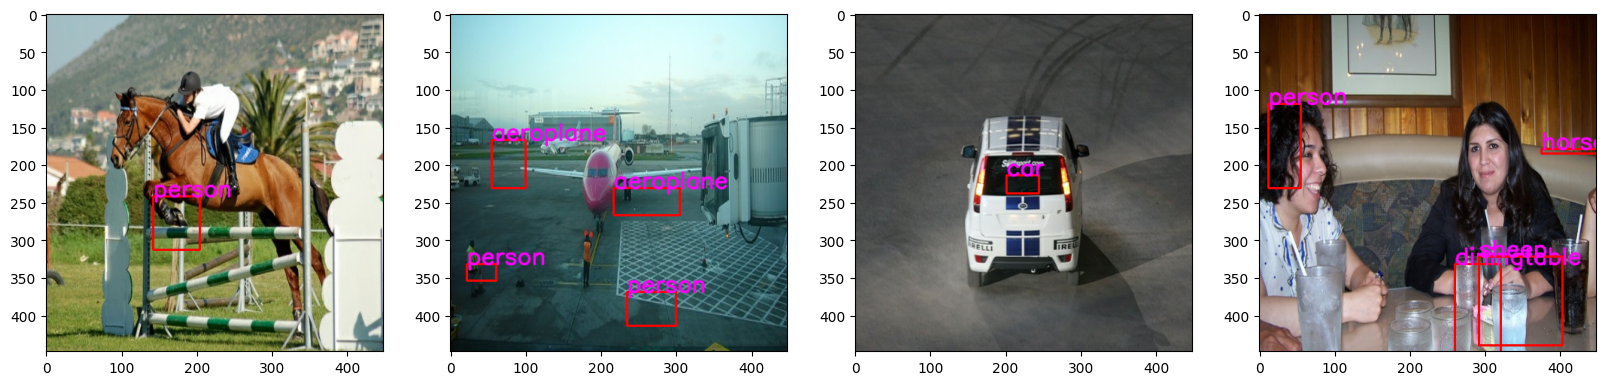

In [26]:
confidence_thresh = 0.4
grid_width = 1 / GRIDS
grid_dimen = np.array([448 * grid_width, 448 * grid_width]).astype(np.int32)
list_classes = list(classes_num)
plots = 4
fig, ax = plt.subplots(ncols=plots, figsize = (20, 20))
for idx in range(plots) :
    sample_image = (res[0][idx] * 255).astype(np.uint8)
    
    for i in range(GRIDS) :
        for j in range(GRIDS) :
            if res[1][idx, i, j, 24] < confidence_thresh: continue 
            sample_coords = res[1][idx,i, j, 20:24] #[x, y, w, h]
            grid_width = 1/7
            
            width = sample_coords[2] * grid_dimen[0] 
            height = sample_coords[3] * grid_dimen[1]
            #width = sample_coords[2] * 448
            #height = sample_coords[3] * 448
            x1 = (j * grid_dimen[0]) + (sample_coords[0] * grid_dimen[0]) - (width / 2)
            y1 = (i * grid_dimen[1]) + (sample_coords[1] * grid_dimen[1]) - (height / 2)
            x2 = x1 + width
            y2 = y1 + height
            
            cv.rectangle(sample_image, 
                         tuple(np.array([x1, y1]).astype(np.int32)),
                         tuple(np.array([x2, y2]).astype(np.int32)),
                         (255, 0, 0),
                         2)
            
            cv.putText(img=sample_image,
                   text = list_classes[int(res[1][idx, i, j, :20].argmax())],
                   org = tuple(np.array([x1, y1]).astype(np.int32)),
                   fontFace = cv.FONT_HERSHEY_SIMPLEX,
                   fontScale = 1,
                   color = (255, 0, 255),
                   thickness =2,
                    lineType = cv.LINE_AA
                   )
    ax[idx].imshow(sample_image)
plt.show()